In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubEvalscriptTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

In [2]:
band_names = [
    "CLOUD_COVER_TOTAL",
    "HUMIDITY",
    "PRECIPITATION",
    "PRESSURE",
    "SOIL_MOISTURE",
    "SUN_DURATION",
    "TEMPERATURE",
    "VAPOR_PRESSURE_DEFICIT",
    "WIND",
]

S2_africa_weather_data_collection = DataCollection.define_byoc(
    "0013507a-de28-4800-a890-394c493a51a3",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)

In [3]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLOUD_COVER_TOTAL", "HUMIDITY", "PRECIPITATION", "PRESSURE","SOIL_MOISTURE", "SUN_DURATION", "TEMPERATURE", "VAPOR_PRESSURE_DEFICIT", "WIND"],
    output: [
        {
          id: "bands",
          bands: 9,
          sampleType: "FLOAT32"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.CLOUD_COVER_TOTAL, sample.HUMIDITY, sample.PRECIPITATION, sample.PRESSURE, sample.SOIL_MOISTURE, sample.SUN_DURATION, sample.TEMPERATURE, sample.VAPOR_PRESSURE_DEFICIT, sample.WIND];
}
"""

In [4]:
download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript,
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
)

In [5]:
bbox = BBox(bbox=[-18, 1, 27.5, 28], crs=CRS.WGS84)

In [6]:
eopatch = download_task.execute(bbox=bbox, time_interval=["2020-08-01", "2020-08-30"])

In [7]:
eopatch

EOPatch(
  data={
    bands: numpy.ndarray(shape=(1, 647, 968, 9), dtype=float32)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-08-01T00:00:00', '2020-08-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 8, 1, 0, 0)]
)

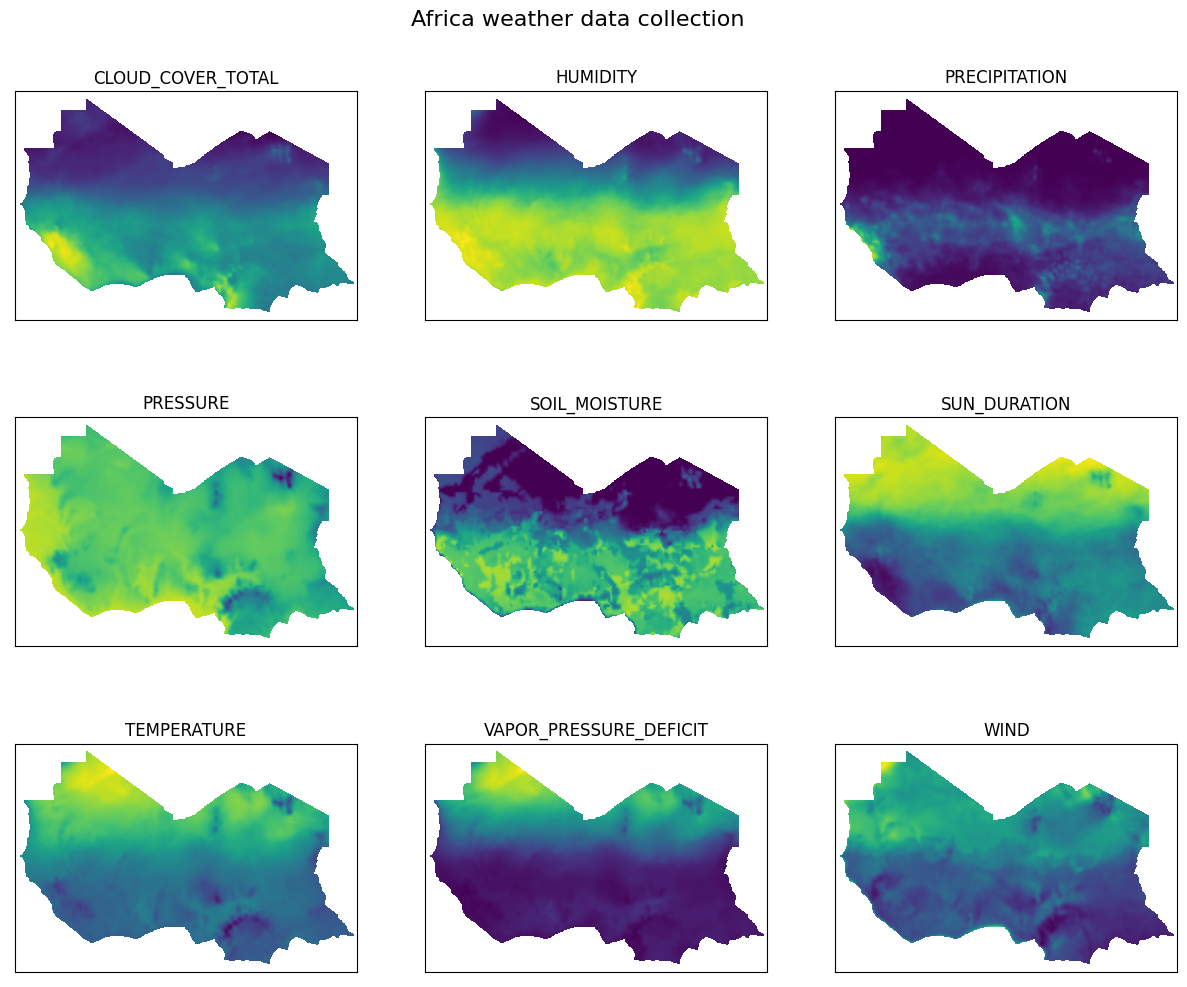

In [21]:
ncols = 3
nrows = math.ceil(len(band_names) / 3)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
fig.suptitle("Africa weather data collection", y=0.93, size=16)

for idx, band in enumerate(band_names):
    ax[idx // ncols][idx % ncols].imshow(eopatch.data["bands"][0][..., idx].squeeze())
    ax[idx // ncols][idx % ncols].set_title(band_names[idx], size=12)
    ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
    ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)

In [10]:
evalscript_precipitation = """
//VERSION=3
function setup() {
  return {
    input: [ "PRECIPITATION"],
    output: [
        {
          id: "bands",
          bands: 1,
          sampleType: "FLOAT32"
        }
    ]
  };
}
function evaluatePixel(sample) {
  return [sample.PRECIPITATION];
}
"""

In [11]:
ps_download_task_precipitation = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_precipitation,
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
)

In [12]:
eopatch_precipitation = ps_download_task_precipitation.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-30"])

In [13]:
eopatch_precipitation

EOPatch(
  data={
    bands: numpy.ndarray(shape=(12, 647, 968, 1), dtype=float32)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-01-01T00:00:00', '2020-12-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0), ..., datetime.datetime(2020, 12, 1, 0, 0)], length=12
)

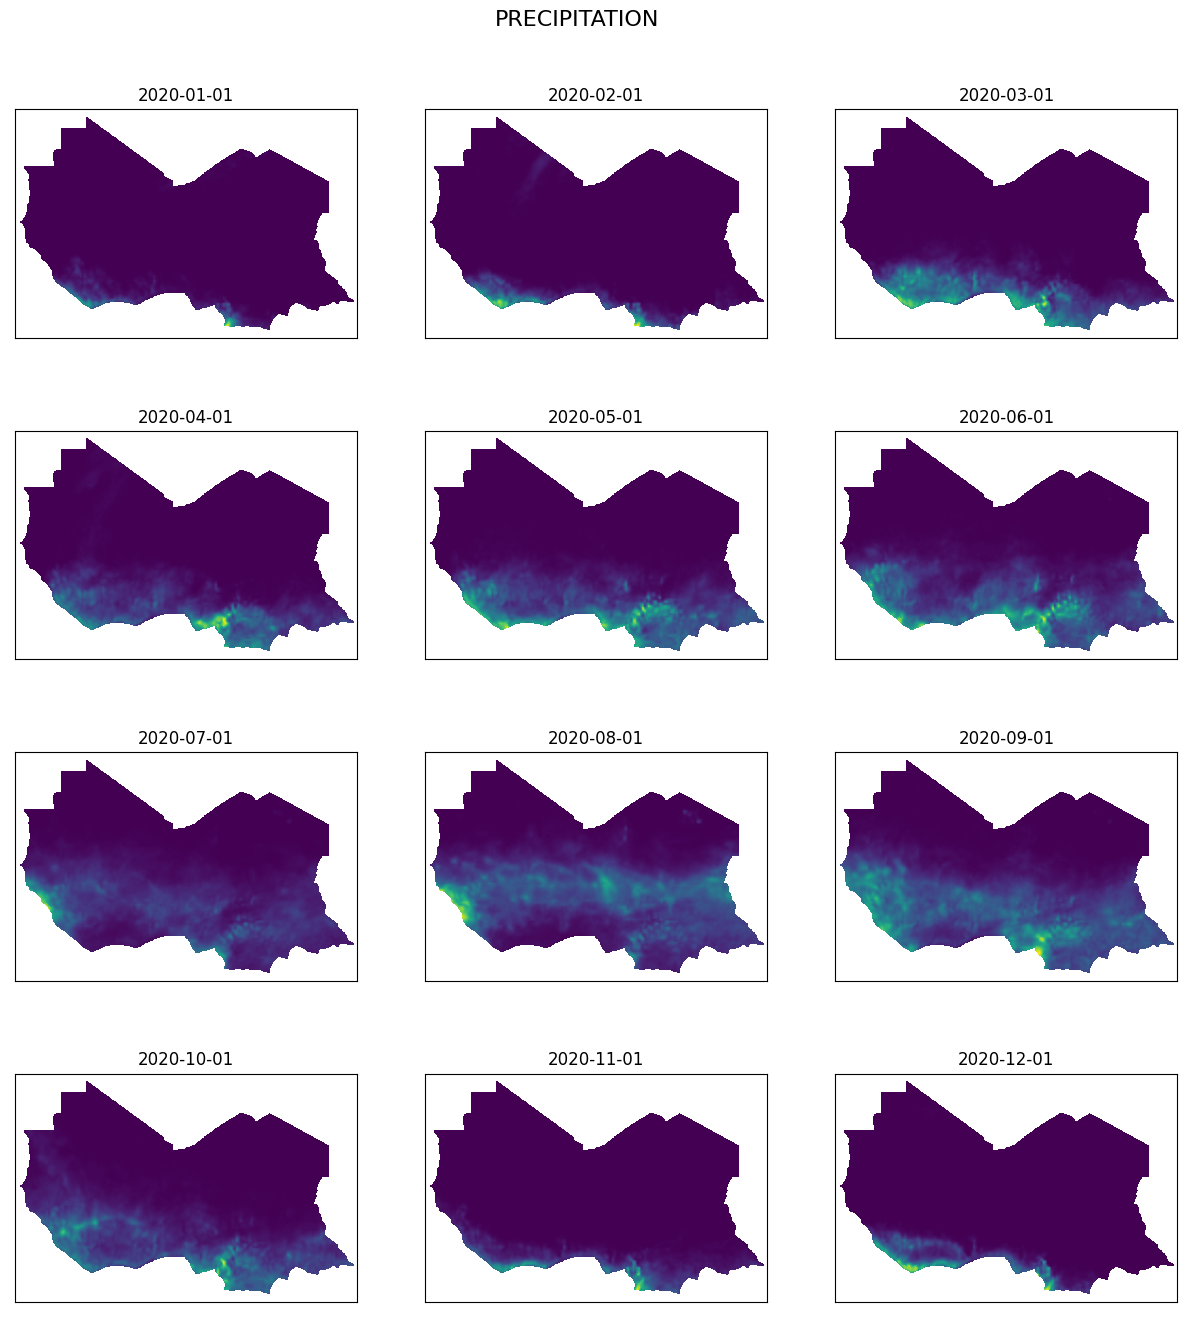

In [20]:
ncols = 3
nrows = math.ceil(len(eopatch_precipitation.timestamp) / 3)

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
fig.suptitle("PRECIPITATION", y=0.93, size=16)

for idx, time_stamp in enumerate(eopatch_precipitation.timestamp):
    ax[idx // ncols][idx % ncols].imshow(eopatch_precipitation.data["bands"][idx][...].squeeze())
    ax[idx // ncols][idx % ncols].set_title(str(eopatch_precipitation.timestamp[idx])[:10], size=12)
    ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
    ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)